# Group Project: Composite Urban Heat Risk Index via PCA

## Data Resources and Usage

The data used in this project comes from two main resources: 

Source (1): The Environment Health Data Portal from nyc.gov (https://a816-dohbesp.nyc.gov/IndicatorPublic/)

Source (2): The NYC Opendata Portal (https://opendata.cityofnewyork.us/)

The dataset we used can be categorized into four main aspects: the heat vulnerability index (HVI) from source (1), the household air conditioner percentage from source (1), the cooling feature data from source (2) that contains the census data from the "Cool It! NYC 2020" project on spray showers, cooling fountains, and other cooling sites; our research also requires the GIS data that help us plot the distribution by NYC's NTA2020 (Neighborhood Tabulation Area) & PUMA2010 from source (2)

## (1) Import packages

We load pandas and geopandas for data manipulation and spatial analysis, matplotlib for plotting, and sklearn for implementing the PCA model. Additionally, a patch for the shapely library is included to prevent common geometry-related errors.

In [53]:
import shapely.geometry.base
if hasattr(shapely.geometry.base.BaseMultipartGeometry, "__array_interface__"):
    del shapely.geometry.base.BaseMultipartGeometry.__array_interface__
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## (2) Prepare the NTA layer, PUMA layer, and overlap layers form AC data

Here, we outline the primary data sources used for our analysis, namely the NYC Environment Health Data Portal and the NYC Open Data Portal. This section details the four key types of data we utilized: the Heat Vulnerability Index (HVI), household air conditioner ownership rates, geographic locations of public cooling features (like spray showers and fountains), and the GIS files needed for mapping.
In this cell, we load the core geographic data: NTA and PUMA shapefiles. We standardize their coordinate reference systems (CRS) for compatibility and then perform a spatial join to match each NTA with its corresponding PUMA. This step is crucial for later integrating the PUMA-level air conditioner data into our NTA-level dataset.

In [104]:
# Load NTA layer
gdf_nta = gpd.read_file("nynta2020.shp").to_crs("EPSG:4326")
gdf_boro = gdf_nta.dissolve(by="BoroName")[["geometry"]].reset_index()

# Load PUMA layer (for AC data)
gdf_puma = gpd.read_file("puma2010.shp")
gdf_puma = gdf_puma.set_crs("EPSG:2263", allow_override=True).to_crs("EPSG:4326")

# compute centroids in projected CRS for accuracy
nta_cent = gdf_nta.to_crs("EPSG:3857").copy()
nta_cent["geometry"] = nta_cent.geometry.centroid
nta_cent = nta_cent.to_crs("EPSG:4326")[["NTAName","geometry"]]
nta_puma = (
    gpd.sjoin(nta_cent, gdf_puma[["PUMA","geometry"]],
              how="left", predicate="within")
    .drop_duplicates("NTAName")[["NTAName","PUMA"]]
)
nta_puma["PUMA"] = nta_puma["PUMA"].astype(str)


# (3) Load and count the cooling features per NTA

The cooling feature consists of spray showers, cooling fountains, and other cooling sites, each of these cooling features has its latitude and longitude, we use the GeoDataFrame to bound the 

This is the core analytical cell of the project, bringing together all data sources. We first load and spatially join cooling feature data to count sites per NTA, then load and merge the HVI and AC percentage data. Finally, we run a Principal Component Analysis (PCA) to compute our composite heat risk index (BABI) and generate a choropleth map to visualize the results across NYC neighborhoods.

In [105]:
# Load & count cooling points per NTA
df_cool = pd.read_csv("nyc_cool.csv")
df_cool = df_cool[df_cool.Status=="Activated"].dropna(subset=["x","y"]).copy()
gdf_cool = gpd.GeoDataFrame(df_cool,
    geometry=gpd.points_from_xy(df_cool.x, df_cool.y),
    crs="EPSG:4326"
)

borough_map = {"B":"Brooklyn","X":"Bronx","M":"Manhattan","m":"Manhattan","Q":"Queens","R":"Richmond"}
layers = {
    "Spray Showers":      "Cool_It__NYC_2020_-_Spray_Showers_20250618.csv",
    "Drinking Fountains": "Cool_It__NYC_2020_-_Drinking_Fountains_20250618.csv"
}
gdfs = {}
for label, fp in layers.items():
    df = pd.read_csv(fp)
    key = "Status" if "Status" in df.columns else "DF Activated"
    df = df[df[key]=="Activated"].dropna(subset=["x","y","Borough"]).copy()
    df["Borough"] = df["Borough"].map(borough_map)
    gdfs[label] = (
        gpd.GeoDataFrame(df,
            geometry=gpd.points_from_xy(df.x, df.y),
            crs="EPSG:2263"
        )
        .to_crs("EPSG:4326")
    )

all_pts = pd.concat([gdfs["Drinking Fountains"], gdfs["Spray Showers"], gdf_cool], ignore_index=True)
all_pts = gpd.GeoDataFrame(all_pts, geometry=all_pts.geometry, crs="EPSG:4326")
pt_join = gpd.sjoin(all_pts, gdf_nta[["NTAName","geometry"]], how="left", predicate="within")
site_counts = pt_join.groupby("NTAName").size().reset_index(name="site_count")

## (4) Load HVI and AC Percentage data

### The bottom two pictures come from the nyc.gov's environment health department which shows the distribution of HVI by NTA in the year of 2023 (top), and the distribution of AC percentage in 2017 (bottom). 

For the aC data we take the 2017 data instead of 2023, because the 2023 data has too much N/A.

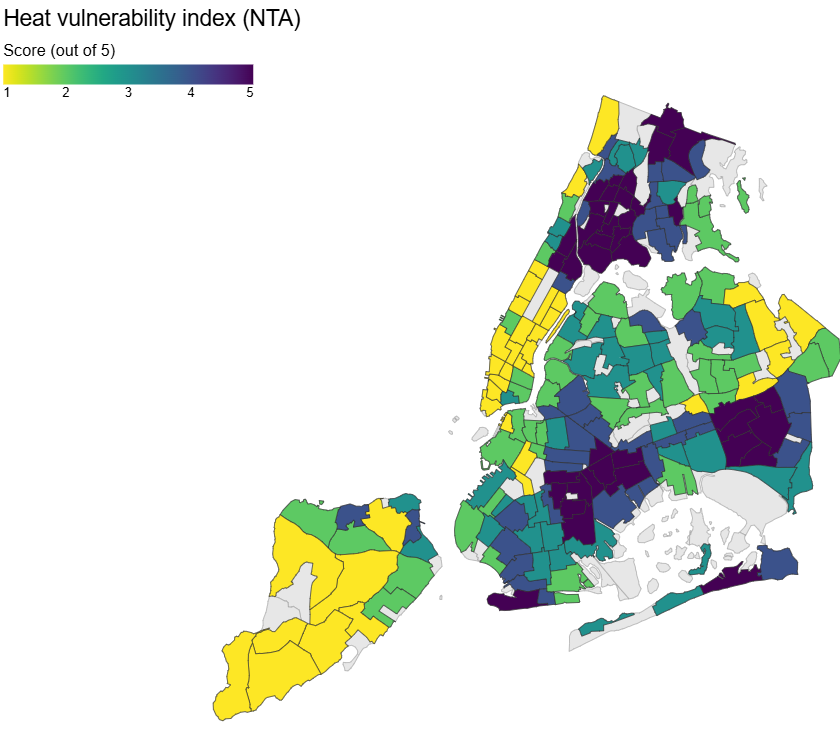

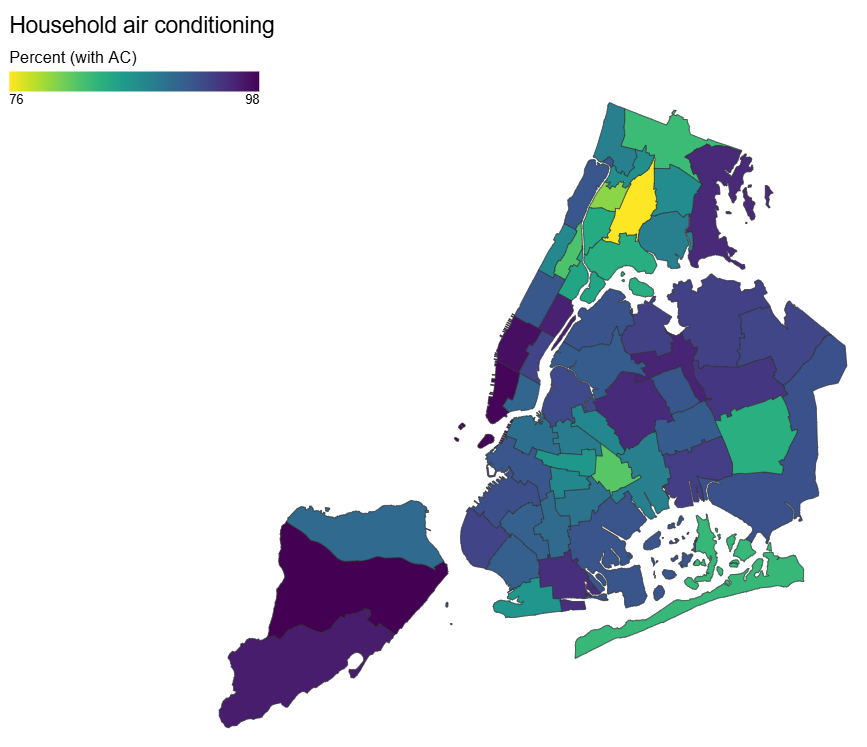

In [106]:
# Load HVI data
hvi_df = pd.read_csv("NYC EH Data Portal - Heat vulnerability index (NTA) (full table) (2).csv")
hvi = (hvi_df
       .rename(columns={"Geography":"NTAName","Score out of 5":"HVI"})
       [["NTAName","HVI"]]
)

# Load 2017 AC% data by PUMA
ac_df = pd.read_csv("NYC EH Data Portal - Household air conditioning (full table) (2).csv")
if "Year" in ac_df.columns:
    ac_df = ac_df[ac_df["Year"] == 2017].copy()
elif "Time Period" in ac_df.columns:
    ac_df = ac_df[ac_df["Time Period"].str.contains("2017")].copy()
ac = (ac_df
      .rename(columns={"GeoID":"PUMA","Percent (with AC)":"AC_pct"})
      [["PUMA","AC_pct"]]
)
ac["AC_pct"] = ac["AC_pct"].str.extract(r"([\d\.]+)").astype(float)
ac["PUMA"]   = ac["PUMA"].astype(str)


# 1) Merge borough names into nhvi
nhvi = nhvi.merge(
    gdf_nta[["NTAName","BoroName"]],
    on="NTAName",
    how="left"
)
borough_means = (
    nhvi.loc[nhvi["AC_pct"] > 0]
        .groupby("BoroName")["AC_pct"]
        .mean()
        .to_dict()
)
global_mean = nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].mean()
def impute_ac(row):
    return row["AC_pct"] if row["AC_pct"] > 0 else borough_means.get(row["BoroName"], global_mean)
nhvi["AC_pct_imputed"] = nhvi.apply(impute_ac, axis=1)

## (5) Bring all data together

In [107]:
# Merge into NHVI table
nhvi = (
    pd.DataFrame({"NTAName":gdf_nta.NTAName})
      .merge(site_counts, on="NTAName", how="left")
      .merge(hvi,         on="NTAName", how="left")
      .merge(nta_puma,    on="NTAName", how="left")
      .merge(ac,          on="PUMA",    how="left")
)
nhvi[["site_count","HVI","AC_pct"]] = nhvi[["site_count","HVI","AC_pct"]].fillna(0)

## (6) Exploratory data input distribution

In [127]:
print("site_count (all values):")
print(nhvi["site_count"].describe(), "\n")
print("HVI (excluding zero values):")
print(nhvi.loc[nhvi["HVI"] > 0, "HVI"].describe(), "\n")
print("AC_pct (excluding zero values):")
print(nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].describe(), "\n")

site_count (all values):
count    912.000000
mean      30.023026
std       32.906656
min        0.000000
25%       14.000000
50%       22.000000
75%       35.000000
max      189.000000
Name: site_count, dtype: float64 

HVI (excluding zero values):
count    743.000000
mean       2.518170
std        1.429146
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: HVI, dtype: float64 

AC_pct (excluding zero values):
count    806.000000
mean      90.825682
std        4.505557
min       70.000000
25%       87.000000
50%       92.000000
75%       93.500000
max       98.600000
Name: AC_pct, dtype: float64 



## Histogram of the input factors

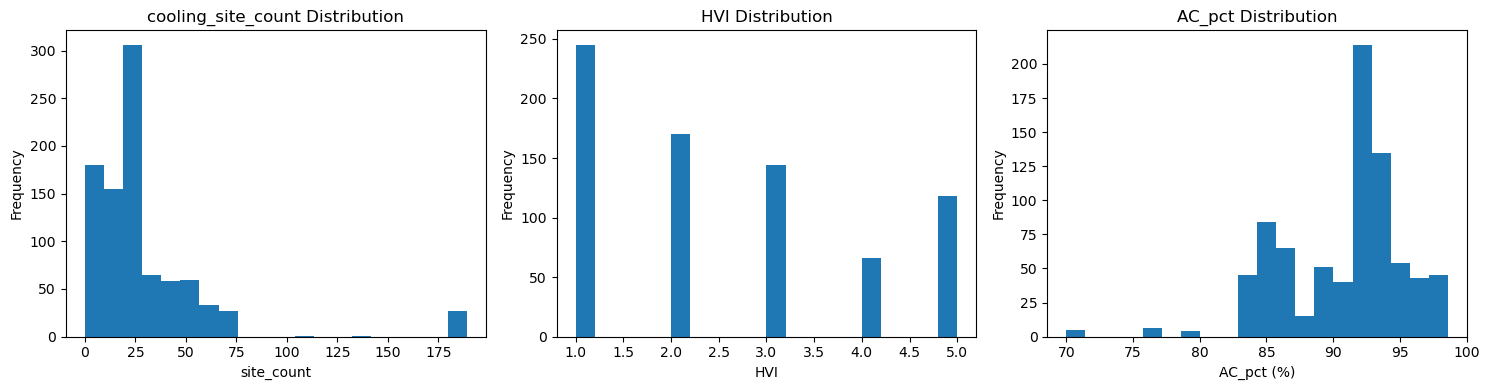

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
nhvi["site_count"].plot.hist(
    bins=20, ax=axes[0], title="cooling_site_count Distribution"
)
axes[0].set_xlabel("site_count")

nhvi.loc[nhvi["HVI"] > 0, "HVI"].plot.hist(
    bins=20, ax=axes[1], title="HVI Distribution"
)
axes[1].set_xlabel("HVI")

nhvi.loc[nhvi["AC_pct"] > 0, "AC_pct"].plot.hist(
    bins=20, ax=axes[2], title="AC_pct Distribution"
)
axes[2].set_xlabel("AC_pct (%)")
plt.tight_layout()
plt.show()

The distribution of the cooling site count skews to left, only 3 NTAs have more than 100 cooling site. The AC percentage data skewed to right.

## The mean value of the imput factors by borough

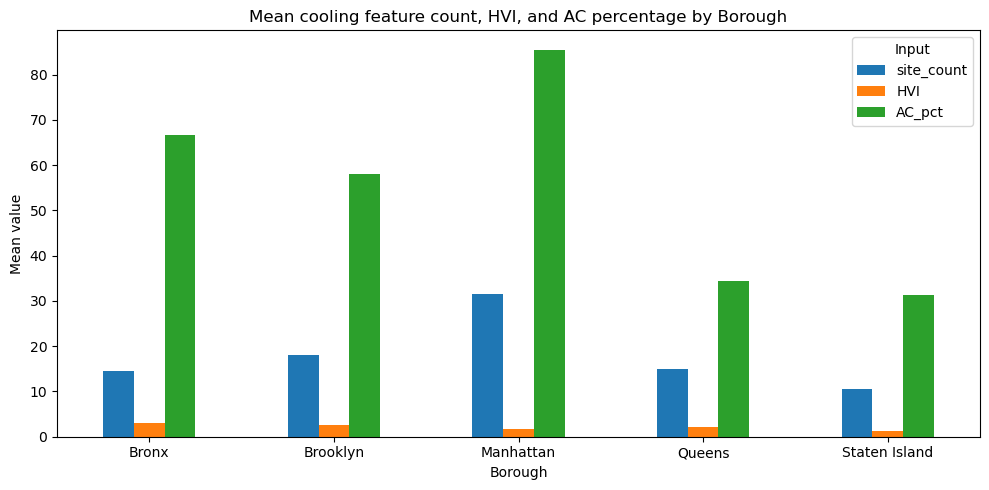

In [110]:
merged = nhvi.merge(gdf_nta[["NTAName","BoroName"]], on="NTAName", how="left")
borough_means = merged.groupby("BoroName")[["site_count","HVI","AC_pct"]].mean()

ax = borough_means.plot(
    kind="bar", figsize=(10,5),
    title="Mean cooling feature count, HVI, and AC percentage by Borough",
    rot=0
)
ax.set_ylabel("Mean value")
ax.set_xlabel("Borough")
ax.legend(title="Input")
plt.tight_layout()
plt.show()


Manhattan has the highest household air conditioner percentage, Staten Island has the lowest cooling site count yet also have the lowest HVI.

## (7) PCA calculation and then merge it back to our NTA map

In [111]:
# Covariance matrix
Xmat = pd.DataFrame({
    "site_count_neg": -nhvi["site_count"],  # more sites → more negative → lower BABI
    "HVI":            nhvi["HVI"],          # higher HVI → higher BABI
    "AC_pct_neg":     -nhvi["AC_pct"]        # more AC → more negative → lower BABI
})

# Standardize
X = StandardScaler().fit_transform(Xmat)
pca = PCA(n_components=1)
nhvi["NHVI"] = pca.fit_transform(X).flatten()

# Normalized
load = pca.components_[0]
weights = abs(load) / abs(load).sum()
print("PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg):",
      dict(zip(Xmat.columns, weights.round(3))))
gdf_nta = gdf_nta.merge(nhvi[["NTAName","NHVI"]], on="NTAName")

PCA‐derived weights (for site_count_neg, HVI, AC_pct_neg): {'site_count_neg': np.float64(0.367), 'HVI': np.float64(0.206), 'AC_pct_neg': np.float64(0.427)}


## (8) Plot the choropleth of our NHVI by NTA.

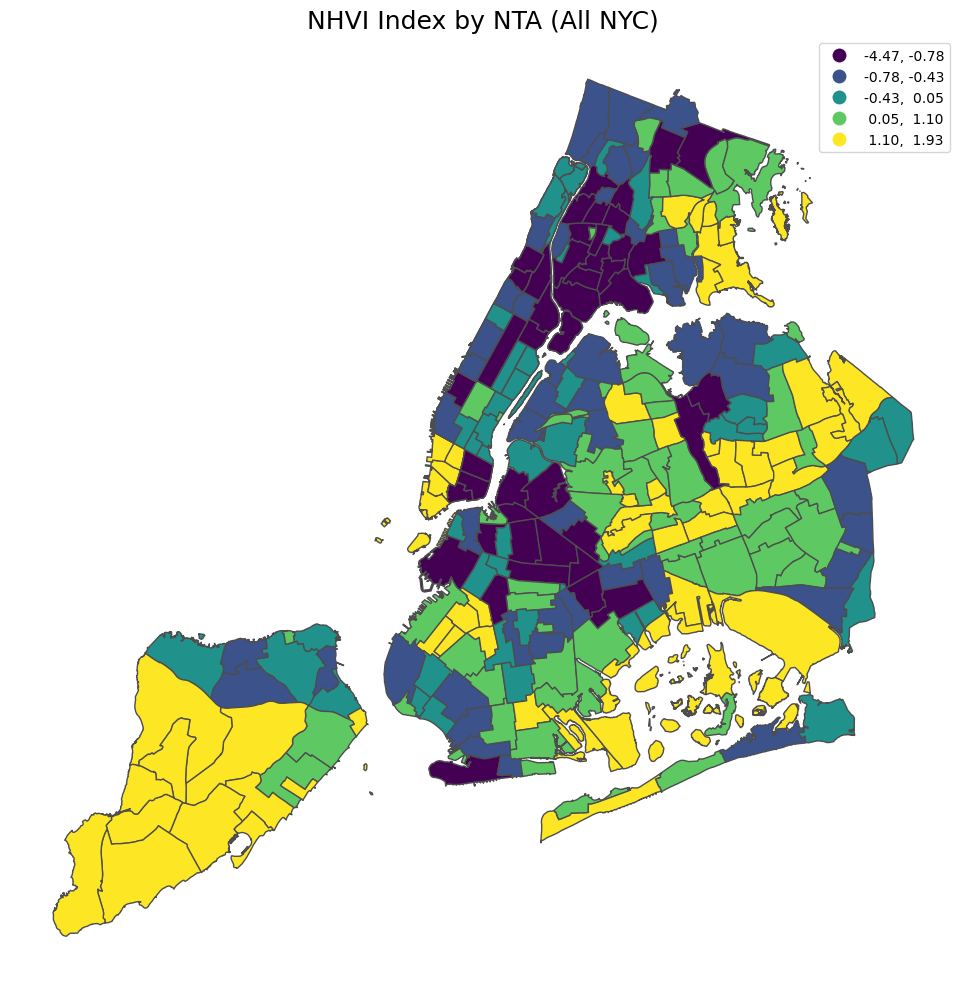

In [112]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_nta.plot(column="NHVI", cmap="viridis", scheme="quantiles",
             legend=True, ax=ax, edgecolor="0.3")
ax.set_title("NHVI Index by NTA (All NYC)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("babi_nyc_choropleth.png", dpi=300)
plt.show()

Our new HVI (NHVI) indicated that most area in Staten Island is in high risk of heat exposure doring extreme heat events, Bronx and Manhattan have relatively low NHVI, while Brooklyn and Queens shows a large variability.

## (9) Plot the PC1 vs PC2 biplot to see how each factor contributes to the two axes, and also their loadings correspondedly. (Each blue points stands for one NTA).

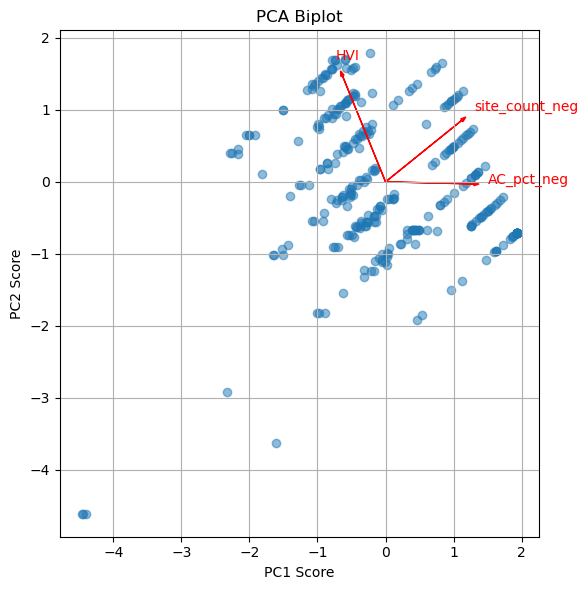

In [114]:
# Fit PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X)      
loadings = pca.components_              

plt.figure(figsize=(6,6))
plt.scatter(scores[:,0], scores[:,1], alpha=0.5)
for i, var in enumerate(Xmat.columns):
    plt.arrow(
        0, 0,
        loadings[0, i] * max(scores[:,0]),
        loadings[1, i] * max(scores[:,1]),
        head_width=0.05, length_includes_head=True, color="red"
    )
    plt.text(
        loadings[0, i] * max(scores[:,0]) * 1.1,
        loadings[1, i] * max(scores[:,1]) * 1.1,
        var,
        color="red"
    )
plt.title("PCA Biplot")
plt.xlabel("PC1 Score")
plt.ylabel("PC2 Score")
plt.grid(True)
plt.tight_layout()
plt.show()


This cell is dedicated to visualizing and interpreting the results of our PCA model. It generates a Biplot to visually demonstrate the relationship between the original variables and the principal components.

The biplot shows each neighborhood on two new axes: **PC1 (horizontal)** captures the “cooling-resource gap” (neighborhoods to the right have few cooling sites and low AC), and **PC2 (vertical)** captures “residual heat exposure” (higher up means a higher HVI after accounting for resources). The red arrows confirm that **site\_count\_neg** and **AC\_pct\_neg** drive PC1, while **HVI** drives PC2. Because many NTAs share identical resource values, you see vertical bands of points that then spread up and down by HVI. Neighborhoods in the top-right quadrant are the most at risk—both resource-poor and highly vulnerable.
